In [53]:
# My initial quick exploration - was done in another repo so some paths and code might need to be adapted ... 
# Just some basic information from the penguin datasets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from geopy.distance import geodesic
import folium
from folium.plugins import HeatMap
from pathlib import Path
import imageio
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [ ]:
files = os.listdir('datasets_penguins')

# combine all datasets into one
df = pd.concat([pd.read_csv('datasets_penguins/' + file) for file in files])

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 415643 entries, 0 to 28175
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dataset_id         415643 non-null  int64  
 1   scientific_name    415643 non-null  object 
 2   common_name        415643 non-null  object 
 3   site_name          415643 non-null  object 
 4   colony_name        415643 non-null  object 
 5   lat_colony         415643 non-null  float64
 6   lon_colony         415643 non-null  float64
 7   device             415643 non-null  object 
 8   bird_id            415643 non-null  object 
 9   track_id           415643 non-null  object 
 10  original_track_id  415643 non-null  int64  
 11  age                415643 non-null  object 
 12  sex                415643 non-null  object 
 13  breed_stage        415643 non-null  object 
 14  breed_status       415643 non-null  object 
 15  date_gmt           415643 non-null  object 
 16  time_gmt

In [21]:
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 dataset_id                0
scientific_name           0
common_name               0
site_name                 0
colony_name               0
lat_colony                0
lon_colony                0
device                    0
bird_id                   0
track_id                  0
original_track_id         0
age                       0
sex                       0
breed_stage               0
breed_status              0
date_gmt                  0
time_gmt                  0
latitude                  0
longitude                 0
argos_quality         99850
equinox              415643
dtype: int64


In [22]:
df = df.drop(columns=['equinox'])

### High level descriptive analysis

In [23]:
# Pinguins tracked
unique_penguins = df['bird_id'].nunique()
print(f"Total unique penguins tracked: {unique_penguins}")

Total unique penguins tracked: 749


common_name
Adelie Penguin       247361
Chinstrap Penguin    114313
Gentoo Penguin        53969
Name: count, dtype: int64


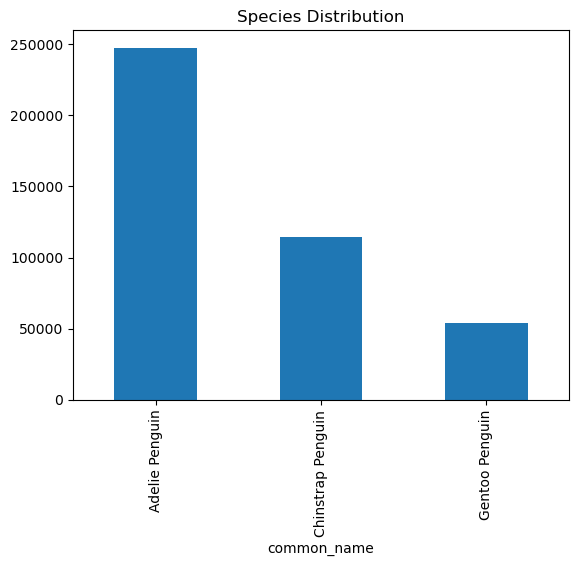

In [24]:
# Distribution of species
species_counts = df['common_name'].value_counts()
print(species_counts)
species_counts.plot(kind='bar', title='Species Distribution')
plt.show()

In [64]:
# Penguins per species
species_penguins = df.groupby('common_name')['bird_id'].nunique()
print(species_penguins)

common_name
Adelie Penguin       178
Chinstrap Penguin    393
Gentoo Penguin       178
Name: bird_id, dtype: int64


Data covers from 1996-10-30 00:00:00 to 2017-02-14 00:00:00


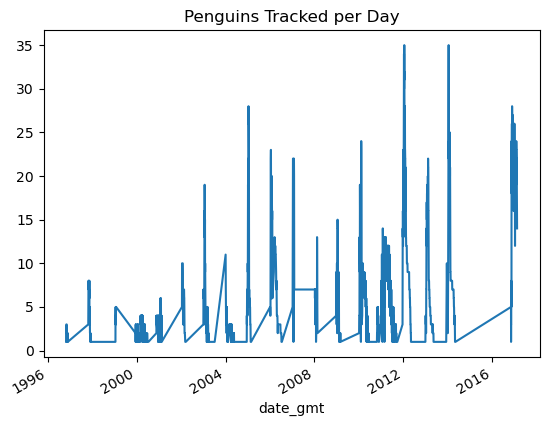

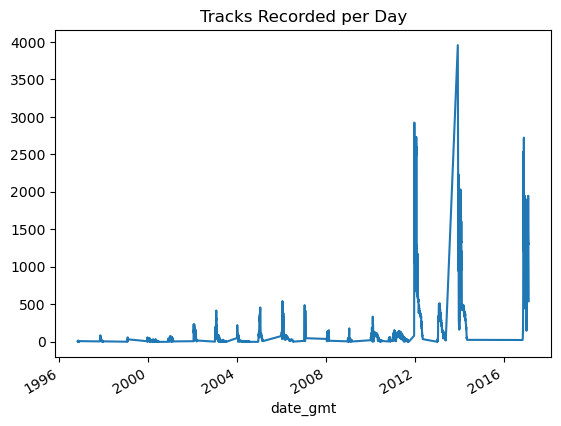

In [36]:
# Date range
df['date_gmt'] = pd.to_datetime(df['date_gmt'])
print(f"Data covers from {df['date_gmt'].min()} to {df['date_gmt'].max()}")


# Number of penguins tracked per day
penguins_per_day = df.groupby('date_gmt')['bird_id'].nunique()
penguins_per_day.plot(title='Penguins Tracked per Day')
plt.show()

# Number tracks recorded per day
tracks_per_day = df.groupby('date_gmt').size()
tracks_per_day.plot(title='Tracks Recorded per Day')
plt.show()

In [38]:
def calculate_distance(row):
    start = (row['lat_colony'], row['lon_colony'])
    end = (row['latitude'], row['longitude'])
    return geodesic(start, end).km

df['distance_from_colony'] = df.apply(calculate_distance, axis=1)
print(df['distance_from_colony'].describe())

count    415643.000000
mean        220.012721
std         352.463297
min           0.000000
25%           7.307134
50%          63.753814
75%         353.551576
max        4799.548546
Name: distance_from_colony, dtype: float64


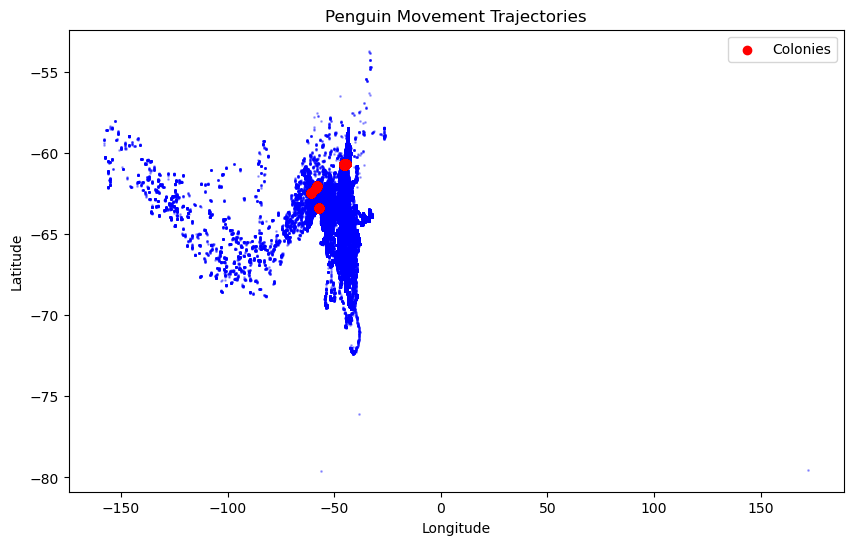

In [39]:
# plotting trajectories
plt.figure(figsize=(10, 6))
plt.scatter(df['longitude'], df['latitude'], c='blue', alpha=0.3, s=1)
plt.scatter(df['lon_colony'], df['lat_colony'], c='red', label='Colonies')
plt.title('Penguin Movement Trajectories')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

/opt/homebrew/anaconda3/envs/dataLiteracy/lib/python3.13/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/homebrew/anaconda3/envs/dataLiteracy/lib/python3.13/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/homebrew/anaconda3/envs/dataLiteracy/lib/python3.13/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


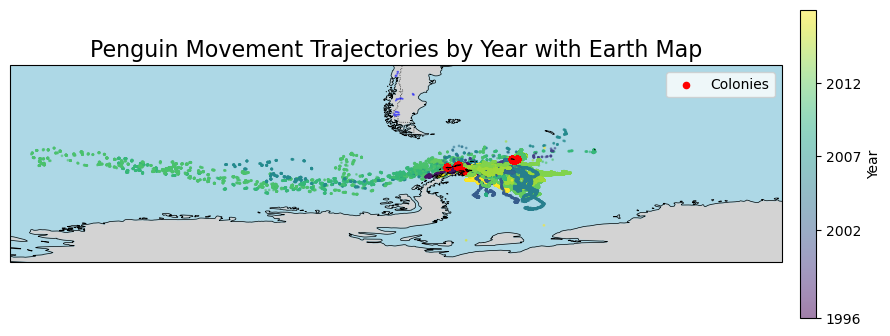

In [87]:
df['year'] = pd.to_datetime(df['date_gmt']).dt.year

# Create the map with a Cartopy projection
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Add features to the map
ax.add_feature(cfeature.LAND, color='lightgray')  # Land in light gray
ax.add_feature(cfeature.OCEAN, color='lightblue')  # Ocean in light blue
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)  # Coastlines
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)  # Borders
ax.add_feature(cfeature.LAKES, color='blue', alpha=0.5)  # Lakes

# Set extent to focus on the region of interest
ax.set_extent([
    df['longitude'].min() - 5, df['longitude'].max() - 155,  # Longitude range
    df['latitude'].min() - 5, df['latitude'].max() + 15     # Latitude range
], crs=ccrs.PlateCarree())

# Scatter plot for trajectories, colored by year
sc = ax.scatter(
    df['longitude'], df['latitude'], c=df['year'], cmap='viridis', alpha=0.5, s=1, transform=ccrs.PlateCarree()
)

# Plot colony locations
ax.scatter(
    df['lon_colony'], df['lat_colony'], c='red', s=20, transform=ccrs.PlateCarree(), label='Colonies'
)

# Add legend
ax.legend(loc='upper right')

# Add color bar for the year
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.02, shrink=0.5)
cbar.set_label('Year')
unique_years = np.unique(df['year'])
cbar.set_ticks(unique_years[0::5])
cbar.set_ticklabels(unique_years[0::5])

# Add title
ax.set_title('Penguin Movement Trajectories by Year with Earth Map', fontsize=16)

# Show the plot
plt.show()


/opt/homebrew/anaconda3/envs/dataLiteracy/lib/python3.13/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/homebrew/anaconda3/envs/dataLiteracy/lib/python3.13/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/homebrew/anaconda3/envs/dataLiteracy/lib/python3.13/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


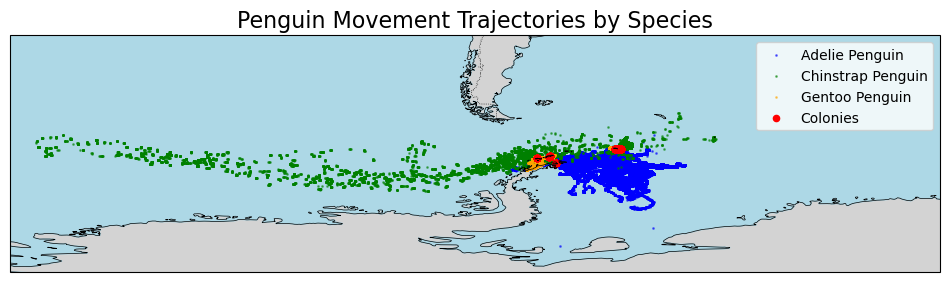

In [78]:
species_colors = {
    'Adelie Penguin': 'blue',    # Replace 'Species1' with actual species names
    'Chinstrap Penguin': 'green',
    'Gentoo Penguin': 'orange'
}   

# Create a new figure with a Cartopy map projection
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Add features to the map
ax.add_feature(cfeature.LAND, color='lightgray')  # Land in light gray
ax.add_feature(cfeature.OCEAN, color='lightblue')  # Ocean in light blue
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)  # Coastlines
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)  # Borders

# Set extent to focus on the region of interest
ax.set_extent([
    df['longitude'].min() - 5, df['longitude'].max() - 155,  # Longitude range
    df['latitude'].min() - 5, df['latitude'].max() + 15     # Latitude range
], crs=ccrs.PlateCarree())

# Plot trajectories for each species
for species, color in species_colors.items():
    subset = df[df['common_name'] == species]  # Filter data by species
    ax.scatter(
        subset['longitude'], subset['latitude'], c=color, alpha=0.5, s=1, 
        transform=ccrs.PlateCarree(), label=species
    )

# Plot colony locations
ax.scatter(
    df['lon_colony'], df['lat_colony'], c='red', s=20, transform=ccrs.PlateCarree(), label='Colonies'
)

# Add legend and title
ax.legend(loc='upper right')
ax.set_title('Penguin Movement Trajectories by Species', fontsize=16)

# Show the plot
plt.show()

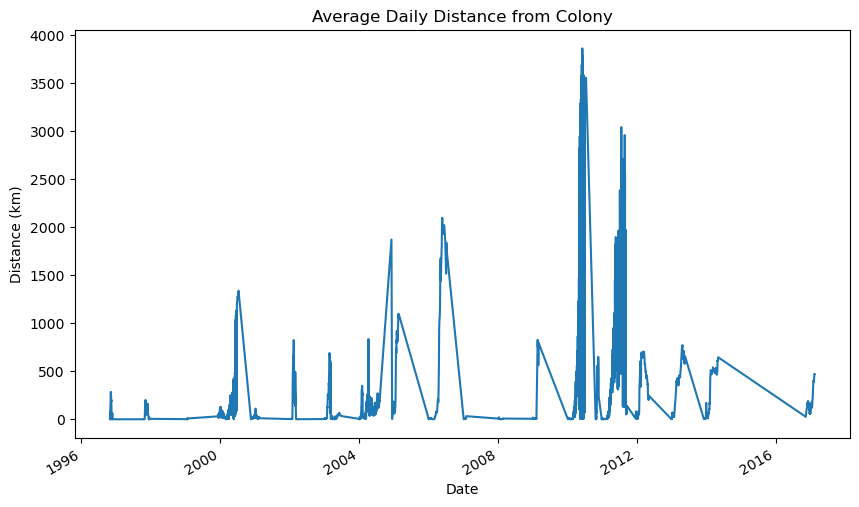

In [42]:
# movement over time
daily_avg_distance = df.groupby('date_gmt')['distance_from_colony'].mean()
daily_avg_distance.plot(title='Average Daily Distance from Colony', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Distance (km)')
plt.show()

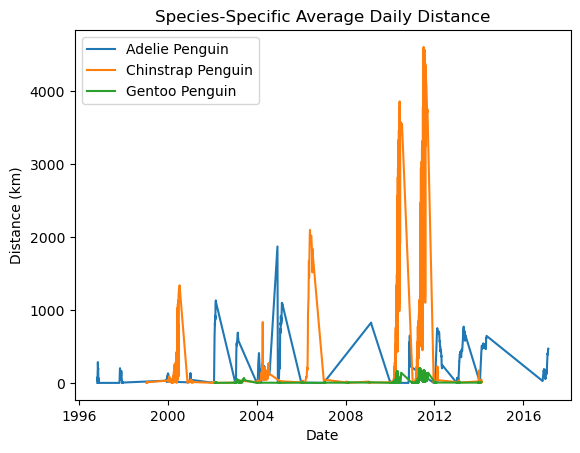

In [43]:
for species in df['common_name'].unique():
    subset = df[df['common_name'] == species]
    daily_avg = subset.groupby('date_gmt')['distance_from_colony'].mean()
    plt.plot(daily_avg, label=species)

plt.title('Species-Specific Average Daily Distance')
plt.xlabel('Date')
plt.ylabel('Distance (km)')
plt.legend()
plt.show()

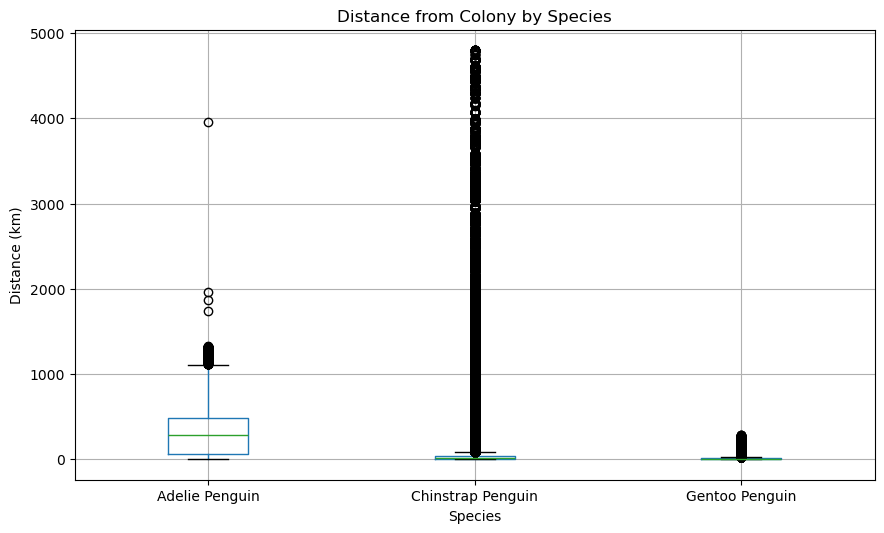

In [44]:
df.boxplot(column='distance_from_colony', by='common_name', figsize=(10, 6))
plt.title('Distance from Colony by Species')
plt.suptitle('')  # Remove default subtitle
plt.ylabel('Distance (km)')
plt.xlabel('Species')
plt.show()


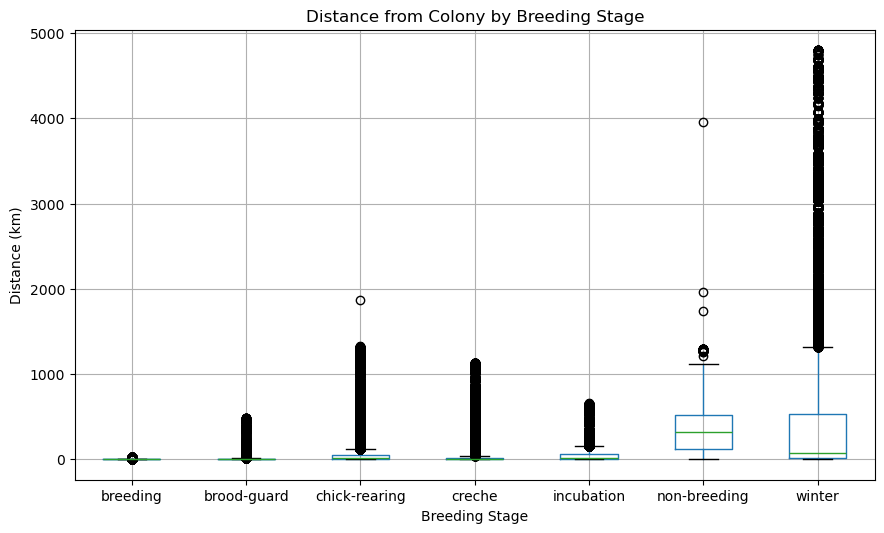

In [45]:
df.boxplot(column='distance_from_colony', by='breed_stage', figsize=(10, 6))
plt.title('Distance from Colony by Breeding Stage')
plt.suptitle('')
plt.ylabel('Distance (km)')
plt.xlabel('Breeding Stage')
plt.show()


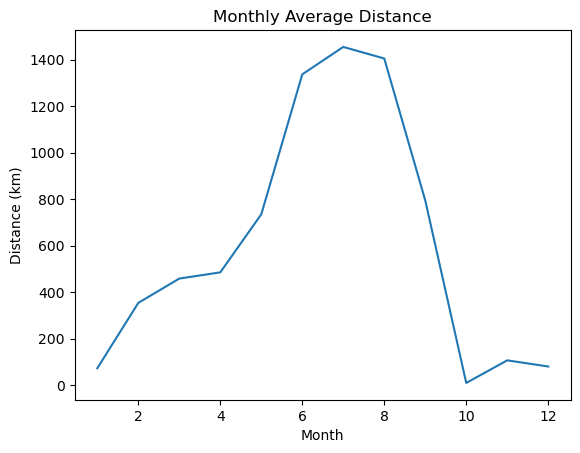

In [46]:
df['month'] = df['date_gmt'].dt.month
monthly_avg_distance = df.groupby('month')['distance_from_colony'].mean()
monthly_avg_distance.plot(title='Monthly Average Distance')
plt.xlabel('Month')
plt.ylabel('Distance (km)')
plt.show()


In [60]:
data = df[(df['date_gmt'] >= '2012-01-01') & (df['date_gmt'] <= '2024-01-31')]
data['data_str'] = data['date_gmt'].dt.strftime('%Y-%m-%d')

# Create a new column for grouping (e.g., daily aggregation)
df['date_str'] = df['date_gmt'].dt.strftime('%Y-%m-%d')

# Group by date and collect lat/lon pairs
grouped_data = df.groupby('date_str')[['latitude', 'longitude']].apply(lambda x: x.values.tolist())
grouped_data_subset = data.groupby('date_str')[['latitude', 'longitude']].apply(lambda x: x.values.tolist())


/var/folders/sd/ks8n1_fs1095g49dhzxt2zvr0000gn/T/ipykernel_21449/1385249793.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['data_str'] = data['date_gmt'].dt.strftime('%Y-%m-%d')


In [62]:
Path("heatmaps").mkdir(exist_ok=True)

# Define the extent of the map (optional: adjust based on your data region)
extent = [
    data['longitude'].min() - 5, data['longitude'].max() + 5,  # Longitude range
    data['latitude'].min() - 5, data['latitude'].max() + 5,    # Latitude range
]

# Generate heatmaps for each day
for date, locations in grouped_data_subset.items():
    # Create a new figure with Cartopy projection
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Add Earth map features
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Add gridlines for reference
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    # Plot movement data points
    ax.scatter(
        [loc[1] for loc in locations],  # Longitude
        [loc[0] for loc in locations],  # Latitude
        color='blue', alpha=0.5, s=5, transform=ccrs.PlateCarree()
    )
    
    # Set the title and labels
    ax.set_title(f'Movement Heatmap for {date}', fontsize=16)

    # Save the figure
    plt.savefig(f"heatmaps/{date}.png", dpi=300, bbox_inches='tight')
    plt.close()

/opt/homebrew/anaconda3/envs/dataLiteracy/lib/python3.13/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/homebrew/anaconda3/envs/dataLiteracy/lib/python3.13/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/homebrew/anaconda3/envs/dataLiteracy/lib/python3.13/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/homebrew/anaconda3/envs/dataLiteracy/lib/python3.13/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/homebrew/anaconda3/envs/dataLiteracy/lib/python3.13/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/homebrew/anaconda3/envs/d

In [63]:
image_files = sorted(Path("heatmaps").glob("*.png"))

# Create a GIF
images = [imageio.imread(str(img)) for img in image_files]
imageio.mimsave("movement_heatmap.gif", images, fps=250)

/var/folders/sd/ks8n1_fs1095g49dhzxt2zvr0000gn/T/ipykernel_21449/958744565.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(str(img)) for img in image_files]


In [88]:
# get the number of different colonies
unique_colonies = df[['lat_colony', 'lon_colony']].drop_duplicates()
print(f"Total number of colonies: {unique_colonies.shape[0]}")

Total number of colonies: 8


In [89]:
# for every colony get the number of penguins, the timespan of data and the average distance from the colony
for i, colony in unique_colonies.iterrows():
    lat, lon = colony
    subset = df[(df['lat_colony'] == lat) & (df['lon_colony'] == lon)]
    num_penguins = subset['bird_id'].nunique()
    timespan = subset['date_gmt'].max() - subset['date_gmt'].min()
    avg_distance = subset['distance_from_colony'].mean()
    print(f"Colony at {lat}, {lon}: {num_penguins} penguins, {timespan.days} days, {avg_distance:.2f} km avg distance")

Colony at -60.73, -45.59: 87 penguins, 4910 days, 255.70 km avg distance
Colony at -62.03, -58.3: 30 penguins, 100 days, 184.76 km avg distance
Colony at -62.47, -60.79: 392 penguins, 5509 days, 260.26 km avg distance
Colony at -60.72, -45.02: 67 penguins, 849 days, 354.05 km avg distance
Colony at -62.18, -58.45: 229 penguins, 6288 days, 90.76 km avg distance
Colony at -60.67, -45.63: 19 penguins, 3302 days, 123.44 km avg distance
Colony at -60.68, -44.59: 59 penguins, 35 days, 43.02 km avg distance
Colony at -63.37, -57.17: 10 penguins, 467 days, 226.28 km avg distance


In [92]:
# Create a map centered at the mean latitude and longitude of the colonies
mean_lat = unique_colonies['lat_colony'].mean()
mean_lon = unique_colonies['lon_colony'].mean()
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=4)

# Add markers for each colony
for i, colony in unique_colonies.iterrows():
    lat, lon = colony
    folium.Marker([lat, lon], popup=f'Colony at {lat}, {lon}').add_to(m)
    # Add a circle around the colony with radius based on the number of penguins
    subset = df[(df['lat_colony'] == lat) & (df['lon_colony'] == lon)]
    num_penguins = subset['bird_id'].nunique()
    # also add to marker info the date range from MM-YYYY to MM-YYYY
    timespan = subset['date_gmt'].min().strftime('%m-%Y') + ' to ' + subset['date_gmt'].max().strftime('%m-%Y')
    folium.Marker(
        location=[lat, lon],
        popup=f'Colony at {lat}, {lon}<br>{num_penguins} penguins<br>{timespan}'
    ).add_to(m)
    
m.save('colonies_map.html')

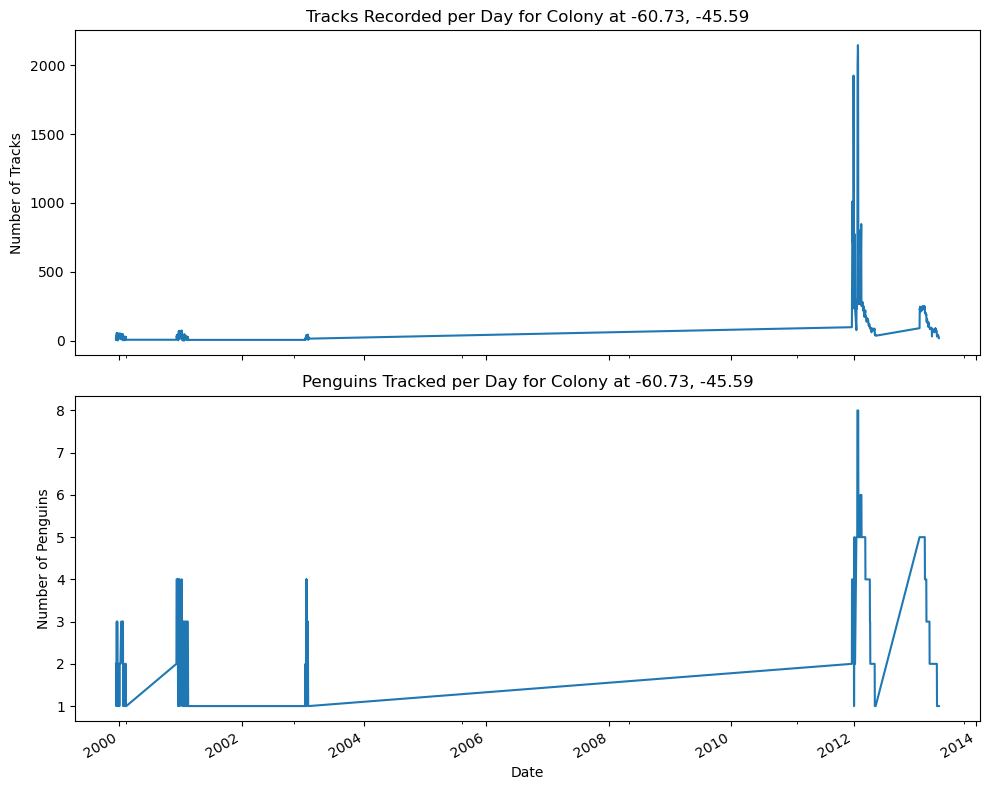

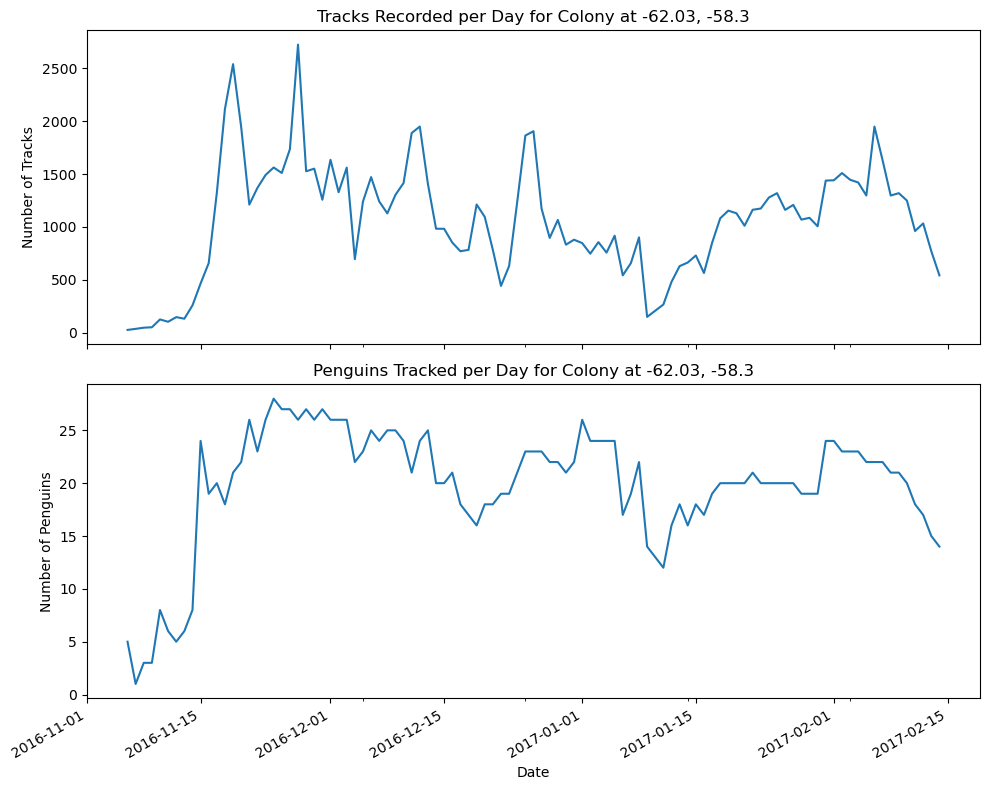

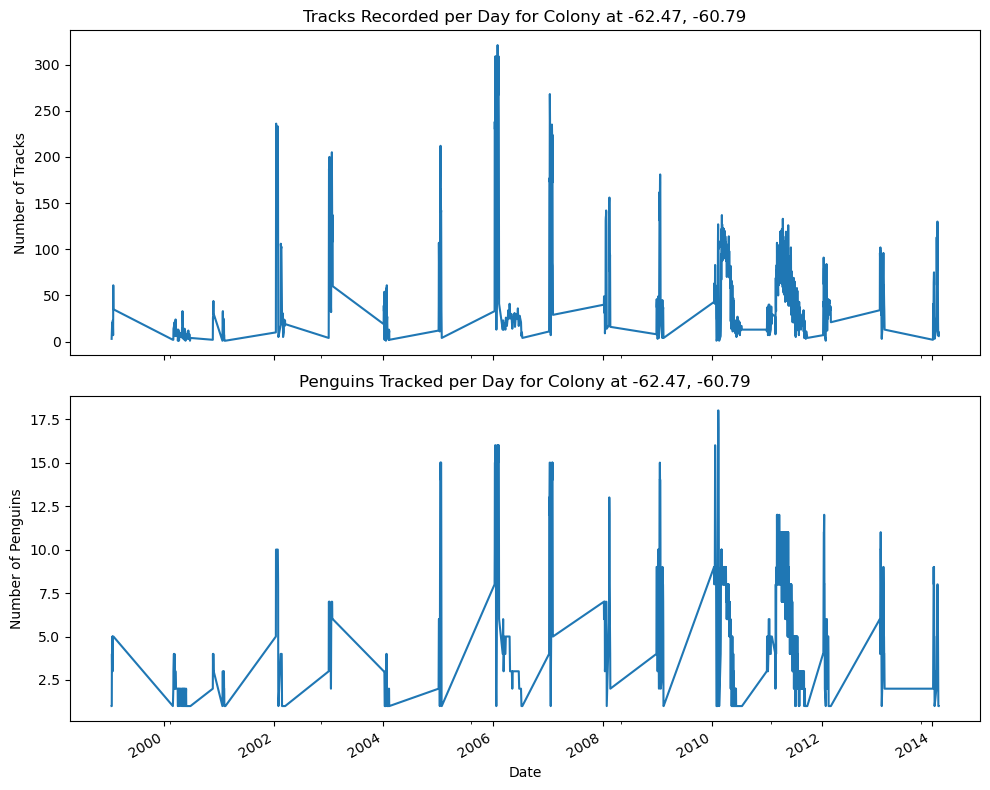

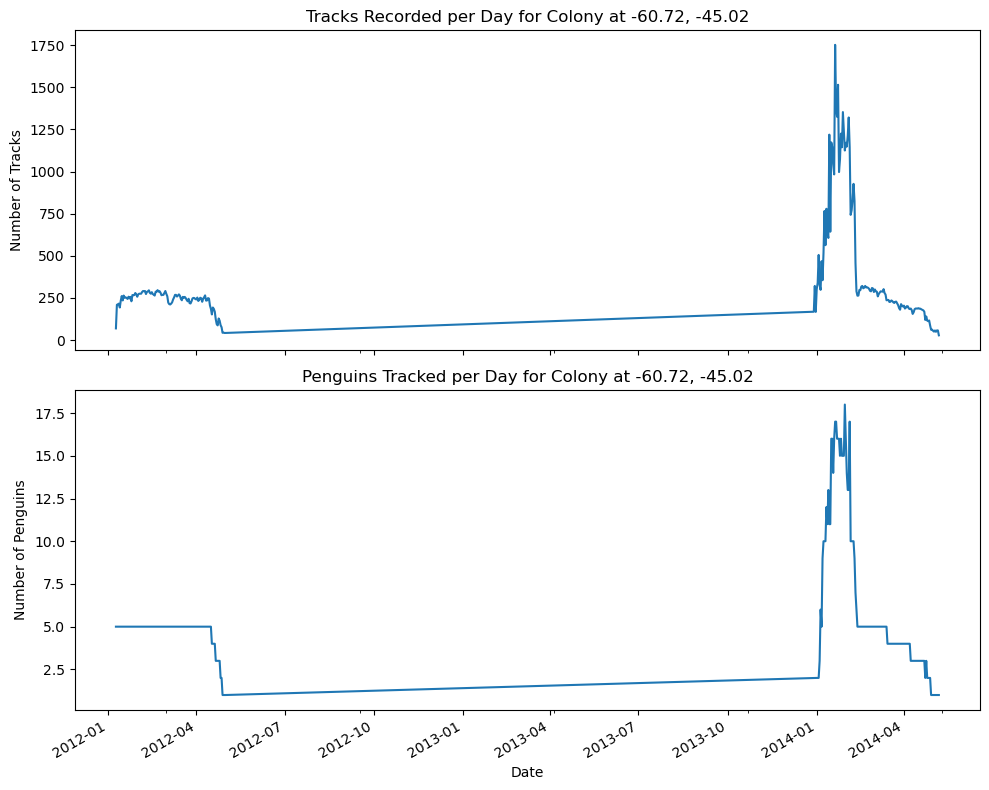

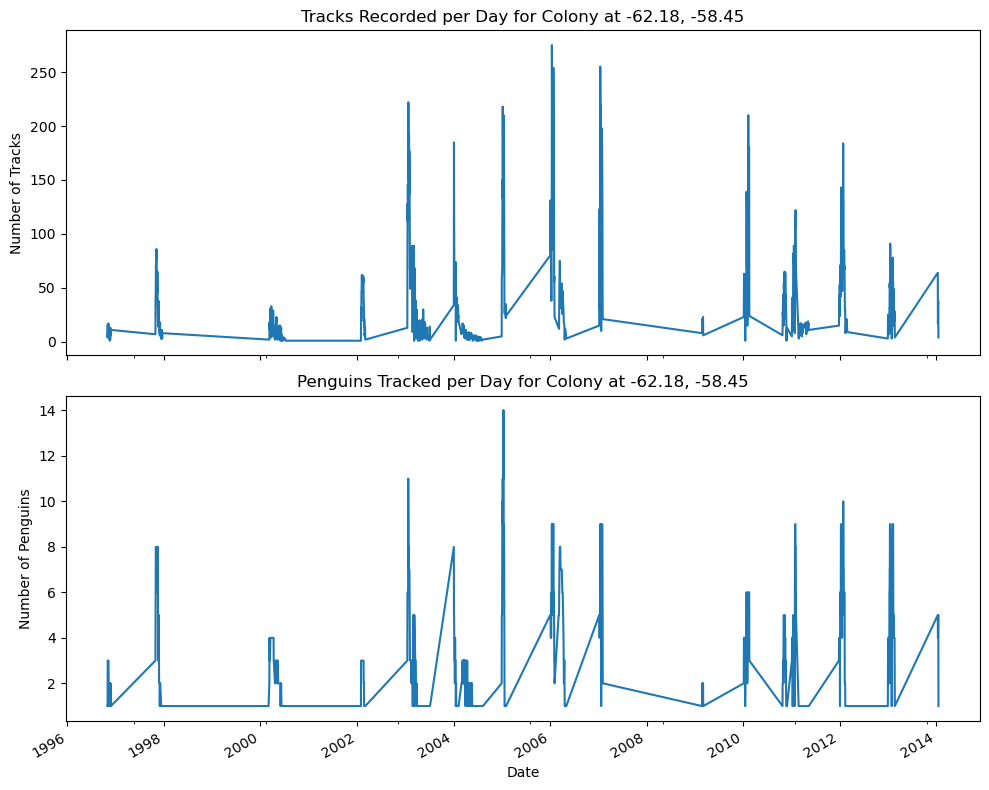

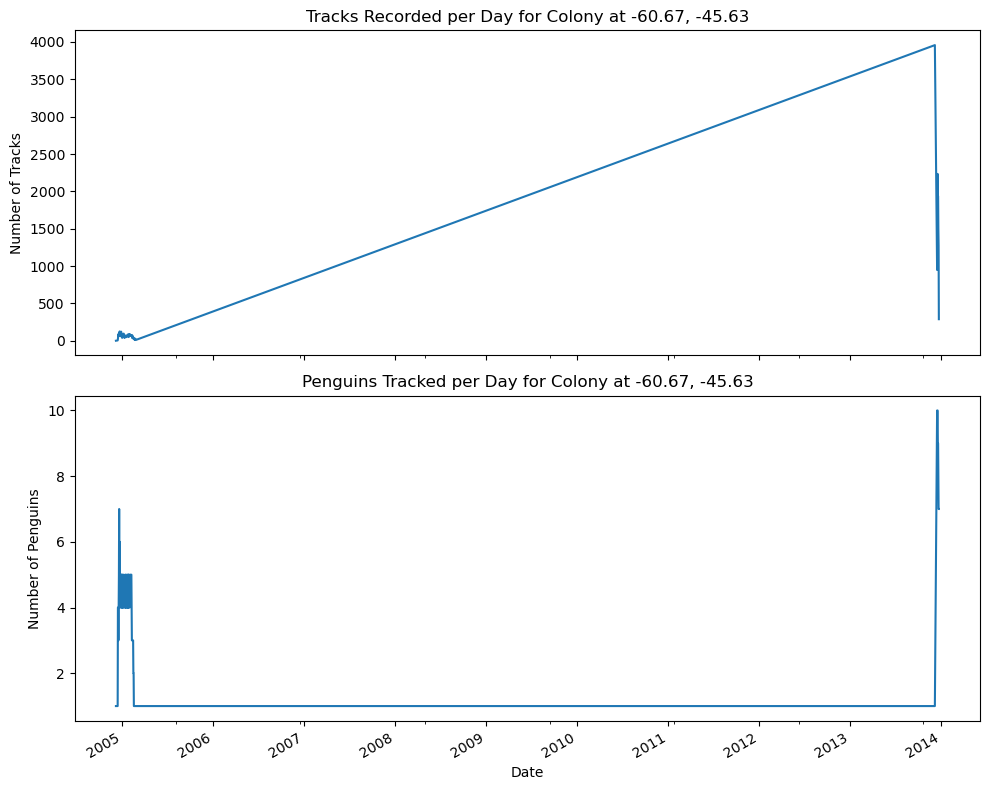

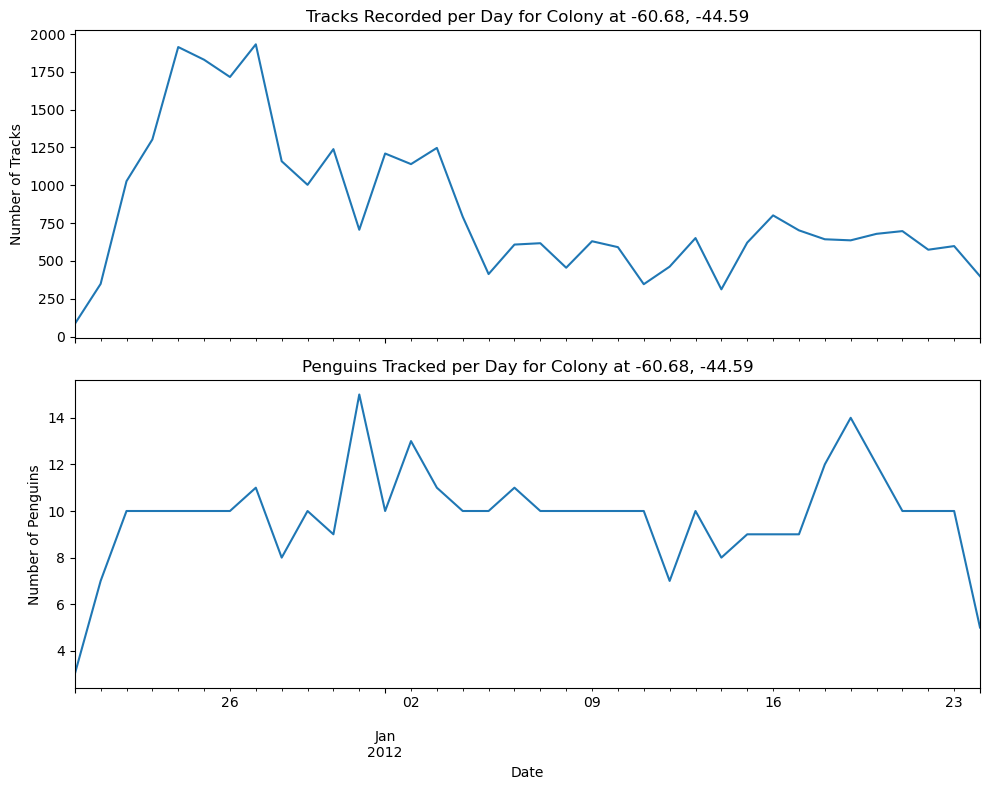

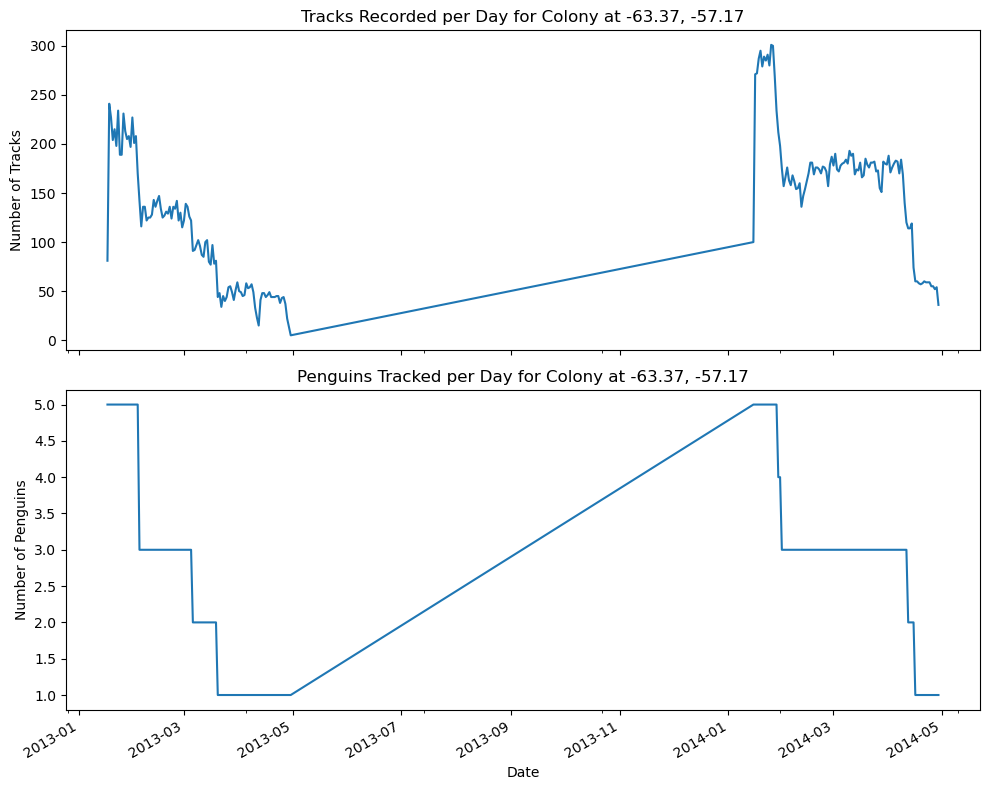

In [94]:
# for each colony plot the number of tracks recorded per day and the number of penguins tracked per day
for i, colony in unique_colonies.iterrows():
    lat, lon = colony
    subset = df[(df['lat_colony'] == lat) & (df['lon_colony'] == lon)]
    tracks_per_day = subset.groupby('date_gmt').size()
    penguins_per_day = subset.groupby('date_gmt')['bird_id'].nunique()
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    # Plot tracks recorded per day
    tracks_per_day.plot(ax=ax[0], title=f'Tracks Recorded per Day for Colony at {lat}, {lon}')
    ax[0].set_ylabel('Number of Tracks')
    
    # Plot penguins tracked per day
    penguins_per_day.plot(ax=ax[1], title=f'Penguins Tracked per Day for Colony at {lat}, {lon}')
    ax[1].set_ylabel('Number of Penguins')
    
    plt.xlabel('Date')
    plt.tight_layout()
    plt.show()

Average number of tracks recorded per penguin: 554.9305740987984


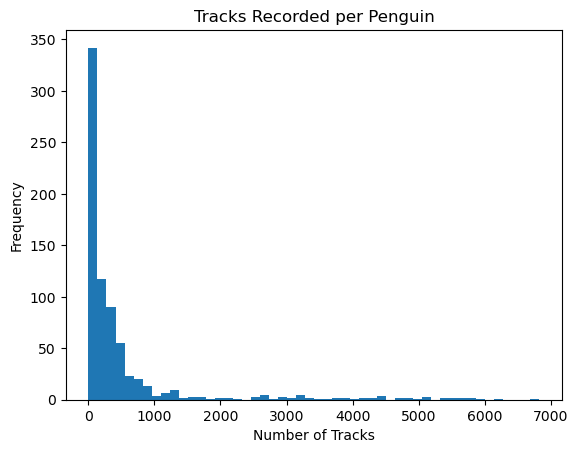

Average tracking frequency (hours): 35.39331777492477


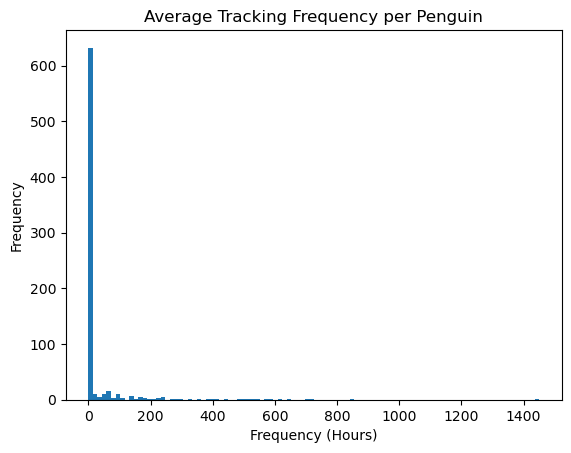

In [102]:
# whats the average number of tracks recorded per bird id and whats the frequency (so e.g. every hour, every day)
tracks_per_bird = df.groupby('bird_id').size()
print(f"Average number of tracks recorded per penguin: {tracks_per_bird.mean()}")
tracks_per_bird.plot(kind='hist', bins=50, title='Tracks Recorded per Penguin')
plt.xlabel('Number of Tracks')
plt.show()


df['date_gmt'] = pd.to_datetime(df['date_gmt'])

# Ensure time_gmt is a string
df['time_gmt'] = df['time_gmt'].astype(str)
df['datetime'] = pd.to_datetime(df['date_gmt'].dt.date.astype(str) + ' ' + df['time_gmt'])

# Sort the data by bird_id and datetime
df = df.sort_values(by=['bird_id', 'datetime'])

# Calculate time differences in seconds
df['time_diff'] = df.groupby('bird_id')['datetime'].diff().dt.total_seconds()

# Average time difference (frequency) per bird_id
average_frequency = df.groupby('bird_id')['time_diff'].mean() / 3600  # Convert to hours
print(f"Average tracking frequency (hours): {average_frequency.mean()}")
average_frequency.plot(kind='hist', bins=100, title='Average Tracking Frequency per Penguin')
plt.xlabel('Frequency (Hours)')
plt.show()



